In [58]:
import sys
import os
import os.path as osp

import straw
from numba import jit, njit
import numpy as np
import math
import argparse
import seaborn as sns
from collections import defaultdict, Counter
import pandas as pd
import time
from pprint import pprint
import pickle

from scipy.stats import gaussian_kde, spearmanr, pearsonr
import scipy.sparse as sps

import matplotlib.pyplot as plt
import matplotlib.colors

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, silhouette_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# os.chdir(os.path.join(os.getcwd(), 'sequences_to_contact_maps'))
# print(os.getcwd())

from importlib import reload
from sequences_to_contact_maps.neural_net_utils.utils import *
# reload(utils)
# from sequences_to_contact_maps.neural_net_utils.utils import *

# from ipynb.fs.defs.plt_fig3 import convertResultToDenseArray

In [2]:
def knightRuizAlg(A, tol=1e-6, f1 = False):
    n = A.shape[0]
    e = np.ones((n,1), dtype = np.float64)
    res = []


    Delta = 3
    delta = 0.1
    x0 = np.copy(e)
    g = 0.9

    etamax = eta = 0.1
    stop_tol = tol*0.5
    x = np.copy(x0)

    rt = tol**2.0
    v = x * (A.dot(x))
    rk = 1.0 - v
#    rho_km1 = np.dot(rk.T, rk)[0, 0]
    rho_km1 = ((rk.transpose()).dot(rk))[0,0]
    rho_km2 = rho_km1
    rout = rold = rho_km1

    MVP = 0 #we'll count matrix vector products
    i = 0 #outer iteration count

    if f1:
        print ("it        in. it      res\n"),

    while rout > rt: #outer iteration
        i += 1

        if i > 30:
            break


        k = 0
        y = np.copy(e)
        innertol = max(eta ** 2.0 * rout, rt)

        while rho_km1 > innertol: #inner iteration by CG
            k += 1
            if k == 1:
                Z = rk / v
                p = np.copy(Z)
                #rho_km1 = np.dot(rk.T, Z)
                rho_km1 = (rk.transpose()).dot(Z)
            else:
                beta = rho_km1 / rho_km2
                p = Z + beta * p

            if k > 10:
                break





            #update search direction efficiently
            w = x * A.dot(x * p) + v * p
           # alpha = rho_km1 / np.dot(p.T, w)[0,0]
            alpha = rho_km1 / (((p.transpose()).dot(w))[0,0])
            ap = alpha * p
            #test distance to boundary of cone
            ynew = y + ap

            if np.amin(ynew) <= delta:

                if delta == 0:
                    break

                ind = np.where(ap < 0.0)[0]
                gamma = np.amin((delta - y[ind]) / ap[ind])
                y += gamma * ap
                break

            if np.amax(ynew) >= Delta:
                ind = np.where(ynew > Delta)[0]
                gamma = np.amin((Delta - y[ind]) / ap[ind])
                y += gamma * ap
                break

            y = np.copy(ynew)
            rk -= alpha * w
            rho_km2 = rho_km1
            Z = rk / v
            #rho_km1 = np.dot(rk.T, Z)[0,0]
            rho_km1 = ((rk.transpose()).dot(Z))[0,0]
        x *= y
        v = x * (A.dot(x))
        rk = 1.0 - v
        #rho_km1 = np.dot(rk.T, rk)[0,0]
        rho_km1 = ((rk.transpose()).dot(rk))[0,0]
        rout = rho_km1
        MVP += k + 1

        #update inner iteration stopping criterion
        rat = rout/rold
        rold = rout
        res_norm = rout ** 0.5
        eta_o = eta
        eta = g * rat
        if g * eta_o ** 2.0 > 0.1:
            eta = max(eta, g * eta_o ** 2.0)
        eta = max(min(eta, etamax), stop_tol / res_norm)
        if f1:
            print ("%03i %06i %03.3f %e %e \n") % \
                (i, k, res_norm, rt, rout),
            res.append(res_norm)
    if f1:
        print ("Matrix - vector products = %06i\n") % \
            (MVP),

    #X = np.diag(x[:,0])
    #x = X.dot(A.dot(X))
    return [x,i,k]

def knightRuiz(A, tol=1e-6, f1 = False):
    result = knightRuizAlg(A, tol, f1)
    col = result[0]
    x = np.diag(col.reshape(-1))
    mtx = x.dot(A.dot(x))

    return mtx

In [ ]:
def plotContactMap(y, ofile = None, title = None, vmin = 0, vmax = 1, size_in = 6, minVal = None, maxVal = None, prcnt = False, cmap = None):
    """
    Plotting function for contact maps.

    Inputs:
        y: contact map numpy array
        ofile: save location
        title: plot title
        vmax: maximum value for color bar, 'mean' to set as mean value
        size_in: size of figure x,y in inches
        minVal: values in y less than minVal are set to 0
        maxVal: values in y greater than maxVal are set to 0
    """
    if cmap is None:
        if prcnt:
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom',
                                                     [(0,       'white'),
                                                      (0.25,    'orange'),
                                                      (0.5,     'red'),
                                                      (0.74,    'purple'),
                                                      (1,       'blue')], N=10)
        else:
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom',
                                                     [(0,    'white'),
                                                      (1,    'red')], N=126)
    if len(y.shape) == 4:
        N, C, H, W = y.shape
        assert N == 1 and C == 1
        y = y.reshape(H,W)
    elif len(y.shape) == 3:
        N, H, W = y.shape
        assert N == 1
        y = y.reshape(H,W)

    if minVal is not None or maxVal is not None:
        y = y.copy() # prevent issues from reference type
    if minVal is not None:
        ind = y < minVal
        y[ind] = 0
    if maxVal is not None:
        ind = y > maxVal
        y[ind] = 0
    plt.figure(figsize = (size_in, size_in))
    if vmin == 'min':
        vmin = np.min(y)
    if vmax == 'mean':
        vmax = np.mean(y)
    elif vmax == 'max':
        vmax = np.max(y)
    ax = sns.heatmap(y, linewidth = 0, vmin = vmin, vmax = vmax, cmap = cmap)
    if title is not None:
        plt.title(title, fontsize = 16)
    plt.tight_layout()
    if ofile is not None:
        plt.savefig(ofile)
    else:
        plt.show()
    plt.close()


In [16]:
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom',
                                             [(0,    'white'),
                                              (1,    'red')], N=126)

mycmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('custom',
                                             [(0,    'white'),
                                              (0.25, 'orange'),
                                              (0.5,    'red'),
                                              (0.74, 'purple'),
                                              (1, 'blue')], N=10)

mycmap3 = matplotlib.colors.LinearSegmentedColormap.from_list('custom',
                                             [(0, 'blue'),
                                             (0.5, 'white'),
                                              (1, 'red')], N=126)


(1024, 2)


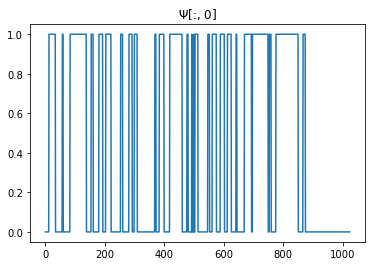

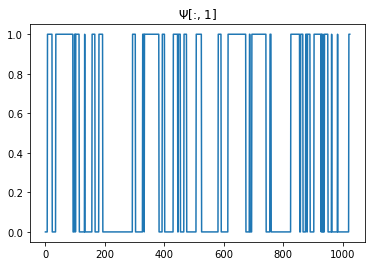

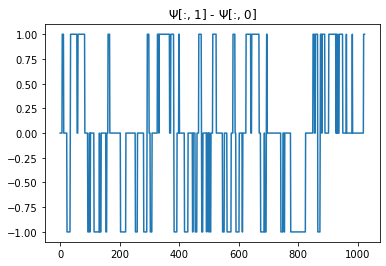

[[-1  1]
 [ 1  0]]


In [68]:
x = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_04_18_21\\samples\\sample40\\x.npy')
print(x.shape)

plt.plot(x[:, 0])
plt.title(r'$\Psi$[:, 0]')
plt.show()

plt.plot(x[:, 1])
plt.title(r'$\Psi$[:, 1]')
plt.show()

minus = x[:,1] - x[:,0]
plt.plot(minus)
plt.title(r'$\Psi$[:, 1] - $\Psi$[:, 0]')
plt.show()

chi = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_04_18_21\\chis.npy')
print(chi)

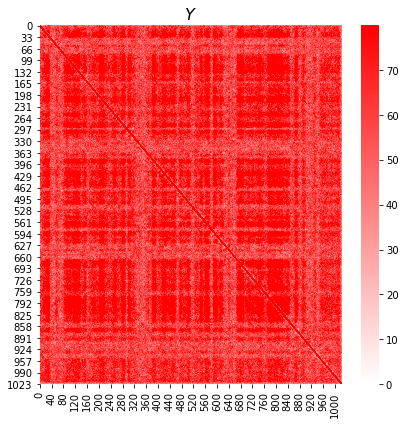

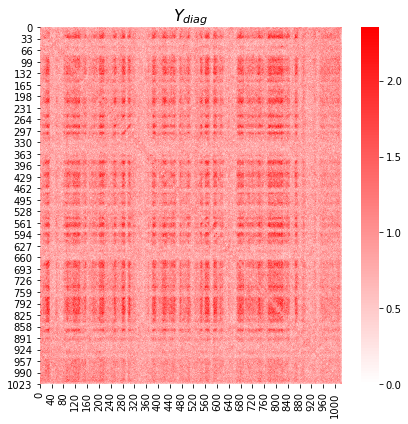

In [69]:
y = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_04_18_21\\samples\\sample40\\y.npy')
plotContactMap(y, vmax = 'mean', title = r'$Y$')

ydiag = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_04_18_21\\samples\\sample40\\y_diag_instance.npy')
plotContactMap(ydiag, vmax = 'max', title = r'$Y_{diag}$')

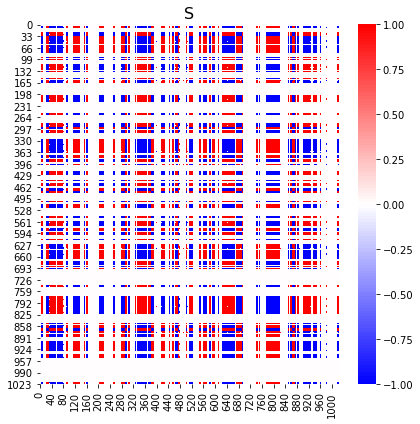

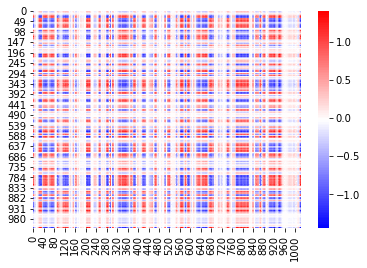

In [70]:
e = np.loadtxt('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\results\\ContactGNNEnergy\\1\\sample40\\energy.txt')
plotContactMap(e, vmin = 'min', vmax = 'max', cmap = mycmap3, title = 'S')

ehat = np.loadtxt('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\results\\ContactGNNEnergy\\1\\sample40\\energy_hat.txt')
ax = sns.heatmap(ehat, linewidth=0, vmin = np.min(ehat), vmax = np.max(ehat), cmap = mycmap3)
plt.show()

[0.5440551  0.01015448 0.00901438 0.00578649 0.00559139]
[153.1205454   20.9189971   19.70969799  15.79136272  15.52286817]


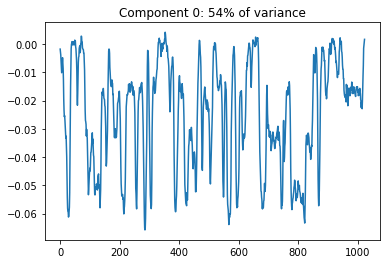

-0.024961410507794116

In [71]:
pca = PCA()
yPCA = pca.fit(ydiag)

print(pca.explained_variance_ratio_[0:5])
print(pca.singular_values_[0:5])
comp1 = pca.components_[0]
plt.plot(comp1)
plt.title("Component 0: 54% of variance")

plt.show()
np.mean(comp1)

[9.99995388e-01 4.03228624e-06 2.63222456e-09 2.55474906e-09
 2.54987443e-09]
[3.87278355e+02 7.77678162e-01 1.98694431e-02 1.95748458e-02
 1.95561619e-02]


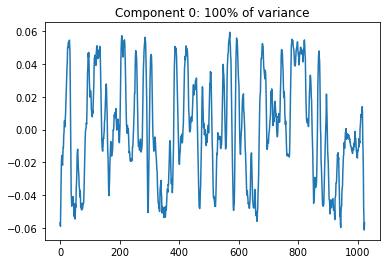

-0.9681965494234914


In [72]:
pca = PCA()
ePCA = pca.fit(ehat)

print(pca.explained_variance_ratio_[0:5])
print(pca.singular_values_[0:5])
comp1ehat = pca.components_[0]

plt.plot(comp1ehat)
plt.title("Component 0: 100% of variance")

plt.show()
np.mean(comp1ehat)

stat, _ = pearsonr(comp1, comp1ehat)
print(stat)

In [73]:
stat, _ = pearsonr(comp1ehat, minus)
print(stat)

-0.9027814075053617


[1.00000000e+00 9.14637379e-28 3.26713247e-28 2.82166944e-28
 2.68450544e-28]
[4.97904288e+02 1.50581056e-11 8.99972498e-12 8.36370938e-12
 8.15789310e-12]


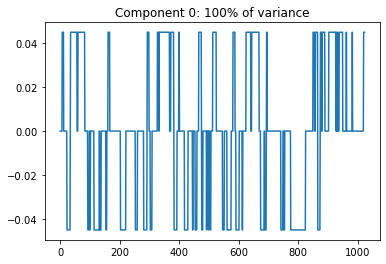

1.0


In [74]:
pca = PCA()
ePCA = pca.fit(e)

print(pca.explained_variance_ratio_[0:5])
print(pca.singular_values_[0:5])
comp1 = pca.components_[0]


plt.plot(comp1)
plt.title('Component 0: 100% of variance')
plt.show()

stat, _ =  pearsonr(comp1, minus)
print(stat)

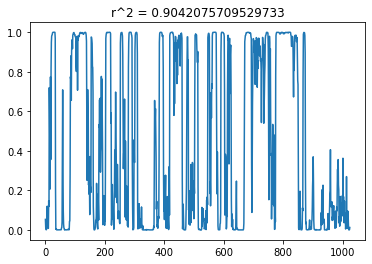

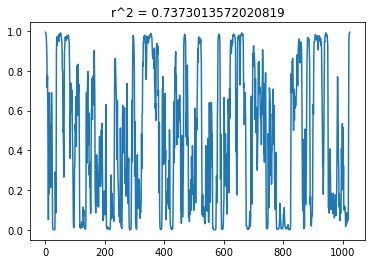

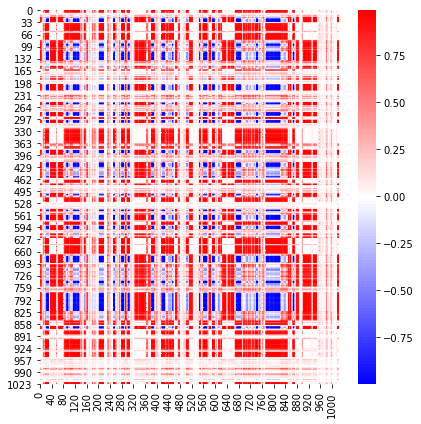

0.18600192311392752

In [75]:
z = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\results\\contactGNN\\224\\sample40\\z.npy')

stat, _ = pearsonr(z[:, 0], x[:, 0])
plt.plot(z[:, 0])
plt.title("r^2 = {}".format(stat))
plt.show()

stat, _ = pearsonr(z[:, 1], x[:, 1])
plt.plot(z[:, 1])
plt.title("r^2 = {}".format(stat))
plt.show()

ehat = z @ chi @ z.T

plotContactMap(ehat, vmin = 'min', vmax = 'max', cmap = mycmap3)

mean_squared_error(ehat, e)

(1024, 4)


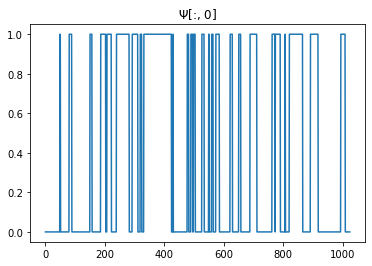

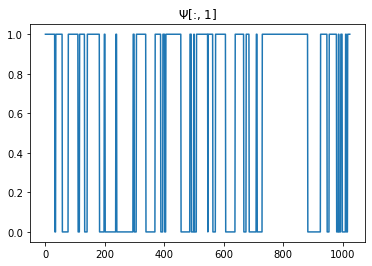

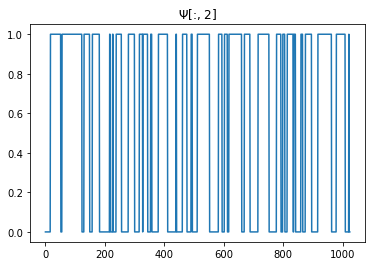

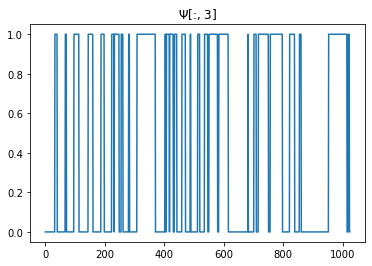

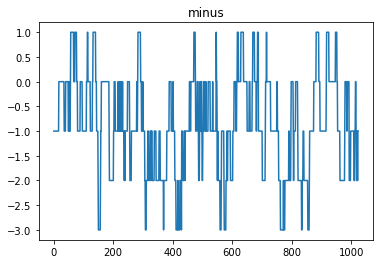

[[-1.   2.  -1.   1.5]
 [ 2.  -1.  -1.  -0.5]
 [-1.  -1.  -1.   1.5]
 [ 1.5 -0.5  1.5 -1. ]]


In [86]:
# dataset 8 26 21

x = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_08_26_21\\samples\\sample40\\x.npy')
print(x.shape)

plt.plot(x[:, 0])
plt.title(r'$\Psi$[:, 0]')
plt.show()

plt.plot(x[:, 1])
plt.title(r'$\Psi$[:, 1]')
plt.show()

plt.plot(x[:, 2])
plt.title(r'$\Psi$[:, 2]')
plt.show()

plt.plot(x[:, 3])
plt.title(r'$\Psi$[:, 3]')
plt.show()

minus = x[:, 2] - x[:, 3] - x[:,1] - x[:,0]
plt.plot(minus)
plt.title('minus')
plt.show()

chi = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_08_26_21\\samples\\sample40\\chis.npy')
print(chi)

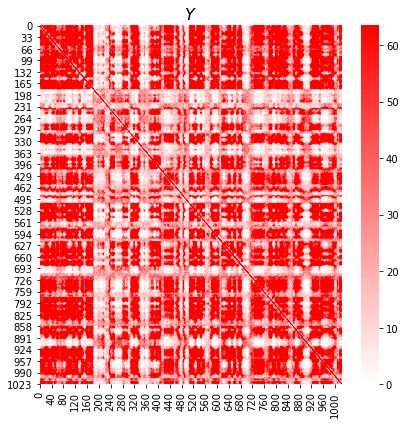

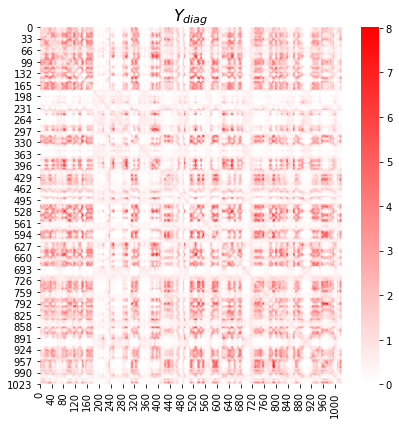

In [79]:
y = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_08_26_21\\samples\\sample40\\y.npy')
plotContactMap(y, vmax = 'mean', title = r'$Y$')

ydiag = np.load('C:\\Users\\Eric\\OneDrive\\Documents\\Research\\Coding\\sequences_to_contact_maps\\dataset_08_26_21\\samples\\sample40\\y_diag_instance.npy')
plotContactMap(ydiag, vmax = 'max', title = r'$Y_{diag}$')

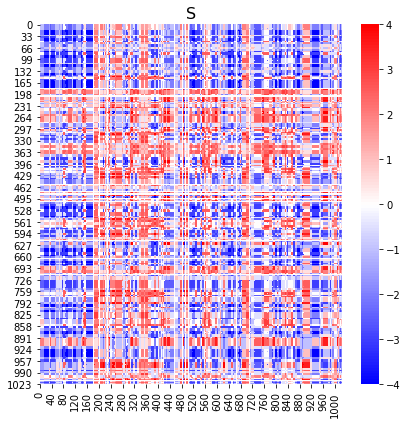

In [80]:
e = x @ chi @ x.T
plotContactMap(e, vmin = 'min', vmax = 'max', cmap = mycmap3, title = 'S')

[0.50985575 0.33495877 0.03568121 0.00821844 0.00618707]
[640.67455598 519.28943807 169.48590083  81.34082641  70.57585823]


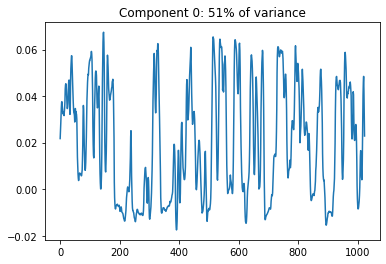

0.020212067849833183

In [81]:
pca = PCA()
yPCA = pca.fit(ydiag)

print(pca.explained_variance_ratio_[0:5])
print(pca.singular_values_[0:5])
comp1 = pca.components_[0]
plt.plot(comp1)
plt.title("Component 0: 51% of variance")

plt.show()

[5.63096363e-01 3.40773943e-01 7.81084191e-02 1.80212746e-02
 2.49830660e-29]
[1.16677848e+03 9.07674715e+02 4.34556221e+02 2.08732368e+02
 7.77176958e-12]


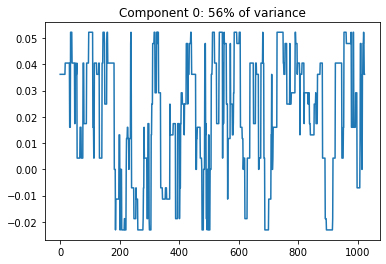

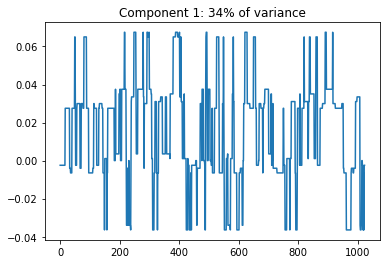

-0.13730715938729318


In [87]:
pca = PCA()
ePCA = pca.fit(e)

print(pca.explained_variance_ratio_[0:5])
print(pca.singular_values_[0:5])


plt.plot(pca.components_[0])
plt.title('Component 0: 56% of variance')
plt.show()

plt.plot(pca.components_[1])
plt.title('Component 1: 34% of variance')
plt.show()

stat, _ =  pearsonr(comp1, minus)
print(stat)
